In [504]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = [16,9]
from statistics import *
import seaborn as sns
sns.set()

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.tsa.api as smt

In [601]:
data = pd.read_csv(r"C:\Users\Madhukar\Documents\Mechine_learning\Projects\Time_series_Arima\testset.csv")

In [602]:
#using interpolate method to impute the missing values
data['Temperature'] = data.Temperature.interpolate(method='linear')

In [603]:
#datetime format
data['datetime'] = pd.to_datetime(data['datetime'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M").strftime("%Y-%m-%d %H:%M")))

In [604]:
data = data.set_index('datetime',drop=True)
data.index.name = 'datetime'

In [605]:
s=[]
for i in range(24):
    s.append(pd.DataFrame(data.resample(rule ='MS',base=i, closed='left', label='left').mean()).reset_index())
    s[i].datetime = pd.to_datetime(s[i].datetime.astype(str)) + pd.DateOffset(hours=i)
data=pd.concat([s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13],s[14],s[15],s[16],s[17],s[18]
             ,s[19],s[20],s[21],s[22],s[23]],ignore_index=True)

In [606]:
data = data.set_index('datetime',drop=True)
data.index.name = 'datetime'

In [607]:
#excluding the missing and retaining years of 12 months data and having similar time in hours (no minutes)
data1=data['2005':'2015']

In [608]:
data2=pd.DataFrame(data1).reset_index()
data2['Temperature']=round(data2['Temperature'],0).astype(int)

In [609]:
data2 = data2.set_index('datetime',drop=True)
data2.index.name = 'datetime'

In [610]:
# using IQR method to display outlier data,IQR is the first quartile subtracted from the third quartile
Q1 = data2.quantile(0.25)
Q3 = data2.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Temperature    12.0
dtype: float64


In [612]:
# removing the outlayers
data_out= data2[~((data2 < (Q1 - 1.5 * IQR)) |(data2 > (Q3 + 1.5 * IQR))).any(axis=1)]
data_out.shape

(3168, 1)

In [613]:
data2=pd.DataFrame(data2).reset_index()

In [614]:
ts = pd.Series(data2['Temperature'].values, index=data2['datetime'])

In [615]:
# applying ADF to check if the series is stationary or not
from statsmodels.tsa.stattools import adfuller
def stationarity_check(tss):
    
    # Determing rolling statistics
    roll_mean = tss.rolling(window=12).mean()
    movingstd= tss.rolling(window=12).std()
    # Plot rolling statistics:
    plt.plot(tss, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.plot(movingstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std')
    plt.show(block=False)
    
    
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(tss)
    print("type of df_test: ",type(df_test))
    print("df_test: ",df_test)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

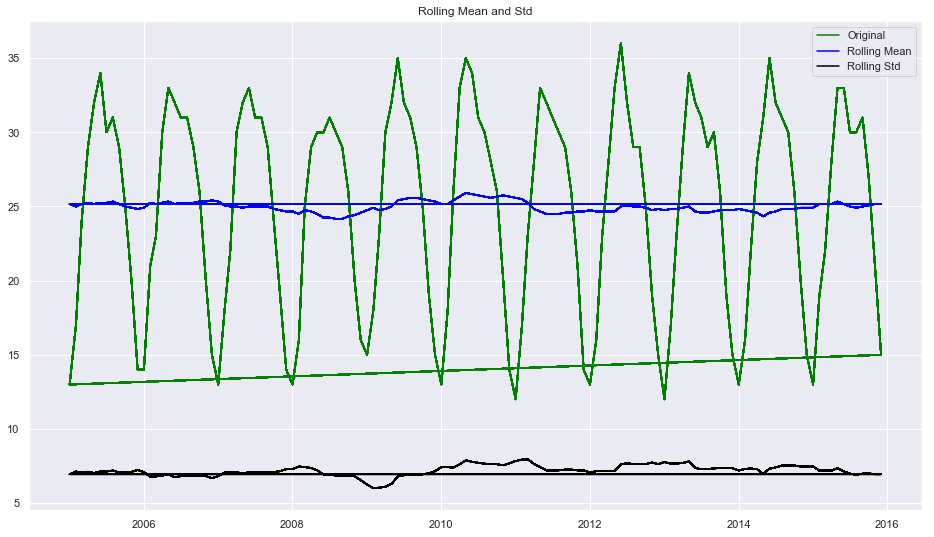

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-19.203826513939894, 0.0, 29, 3138, {'1%': -3.432435614191757, '5%': -2.862461495644756, '10%': -2.5672605338292387}, 8905.667598280474)
df_output: 
 Test Statistic                  -19.203827
p-value                           0.000000
#Lags Used                       29.000000
Number of Observations Used    3138.000000
dtype: float64
Test Statistic                  -19.203827
p-value                           0.000000
#Lags Used                       29.000000
Number of Observations Used    3138.000000
Critical Value (1%)              -3.432436
Critical Value (5%)              -2.862461
Critical Value (10%)             -2.567261
dtype: float64


In [616]:
stationarity_check(ts)

### From the above ADF test, p< 0.05 implies that the series does not have a unit root and test statistics < critical values, so we reject null hypothesis and the series is stationary.¶

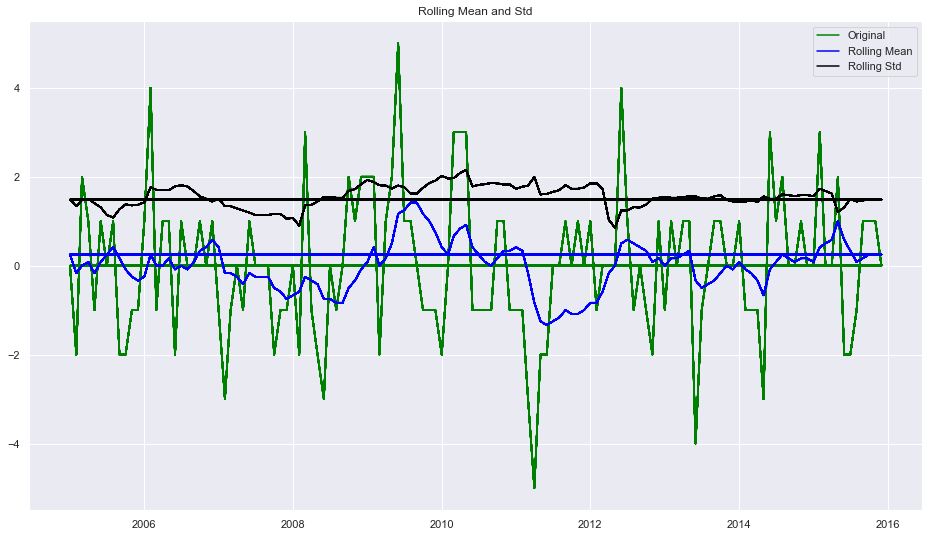

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-16.347093870714684, 2.9571317712470144e-29, 28, 3127, {'1%': -3.432442956894136, '5%': -2.8624647387618434, '10%': -2.5672622604109643}, 9205.016905858374)
df_output: 
 Test Statistic                -1.634709e+01
p-value                        2.957132e-29
#Lags Used                     2.800000e+01
Number of Observations Used    3.127000e+03
dtype: float64
Test Statistic                -1.634709e+01
p-value                        2.957132e-29
#Lags Used                     2.800000e+01
Number of Observations Used    3.127000e+03
Critical Value (1%)           -3.432443e+00
Critical Value (5%)           -2.862465e+00
Critical Value (10%)          -2.567262e+00
dtype: float64


In [617]:
# Apply differencing and power transformation to remove trend, sesonality and noise.

## since there is no exponential trend we are using the series to fit the model

log_series = np.log(ts)

series_diff = ts.diff(12)
series_diff = series_diff.dropna()

#log_series_diff = log_series.diff()
#log_series_diff = log_series_diff.dropna()

stationarity_check(series_diff)

### From previous week Differencing of data transformation has better performance compared to other transformations

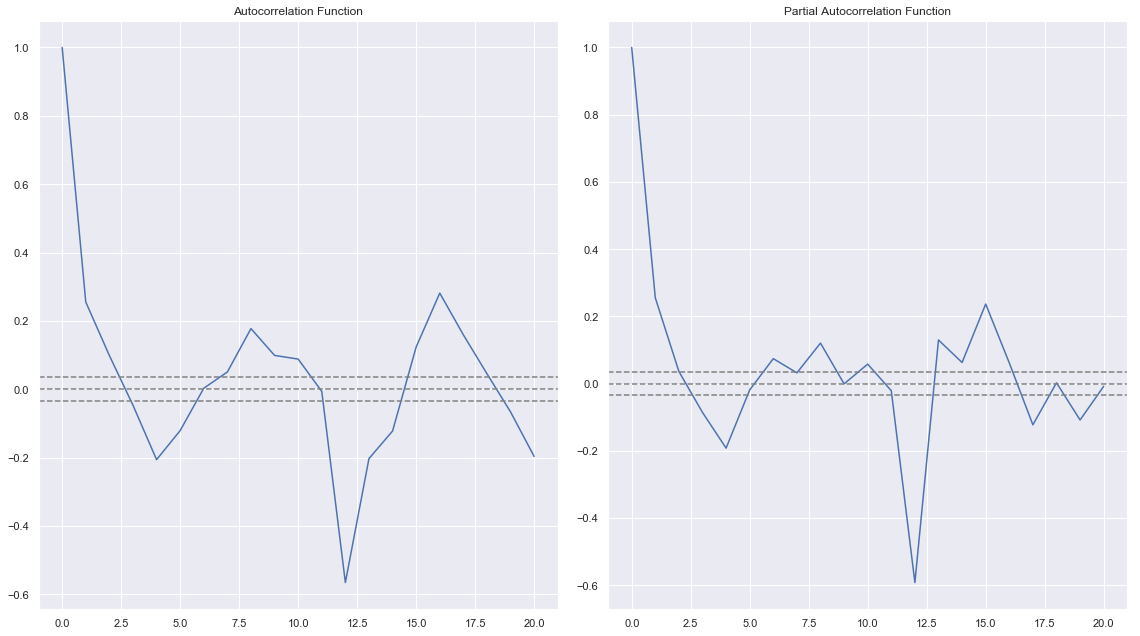

In [618]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(series_diff, nlags=20)
lag_pacf = pacf(series_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

From the above plots p = 2 and q between 2 and 3

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3167
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -6558.133
Method:                       css-mle   S.D. of innovations              1.914
Date:                Mon, 03 Aug 2020   AIC                          13130.267
Time:                        00:44:46   BIC                          13172.691
Sample:                             1   HQIC                         13145.484
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.354e-07   6.75e-06     -0.079      0.937   -1.38e-05    1.27e-05
ar.L1.D.y      1.6736      0.006    275.350      0.000       1.662       1.685
ar.L2.D.y     -0.9420      0.00

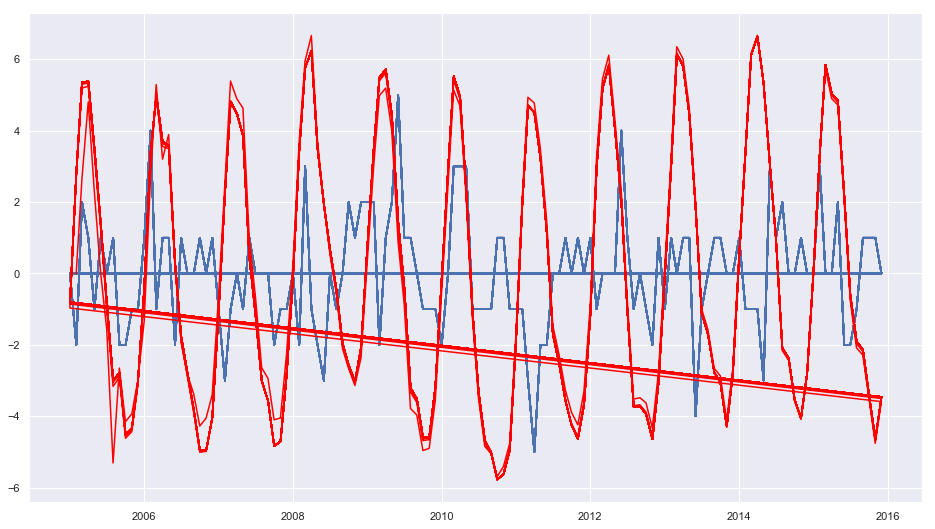

In [619]:
model = ARIMA(ts, order=(2,1,3))
results_ARIMA = model.fit(disp=-1)
plt.plot(series_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())

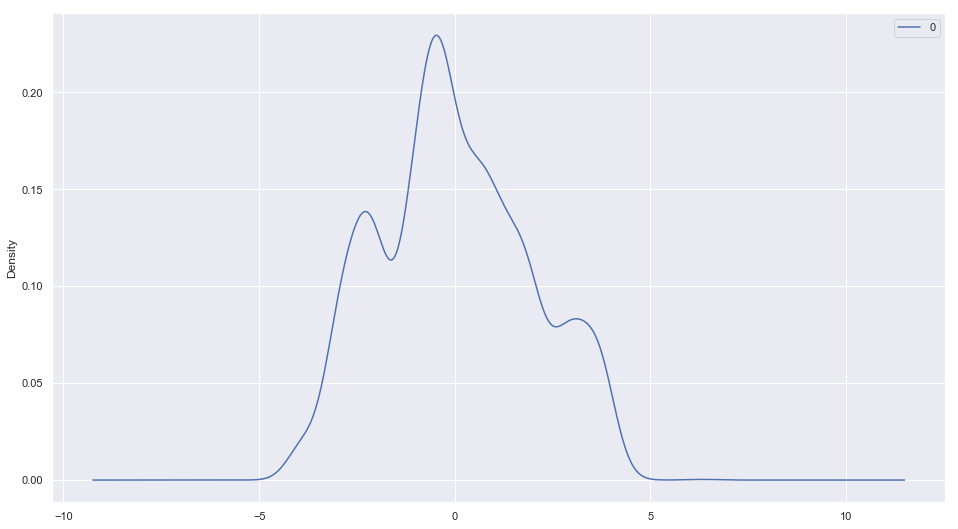

In [620]:
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.show()

In [621]:
print(residuals.describe())

                 0
count  3167.000000
mean      0.008157
std       1.921378
min      -4.063823
25%      -1.348775
50%      -0.169877
75%       1.369422
max       6.305589


### From the above description and chart , mean is close to zero(less error)

In [622]:
pred = pd.Series(results_ARIMA.fittedvalues, copy=True)
pred_sum = pred.cumsum()

In [623]:
pred_log = pd.Series(ts.iloc[0], index=ts.index)
pred_log = pred_log.add(pred_sum, fill_value=0)

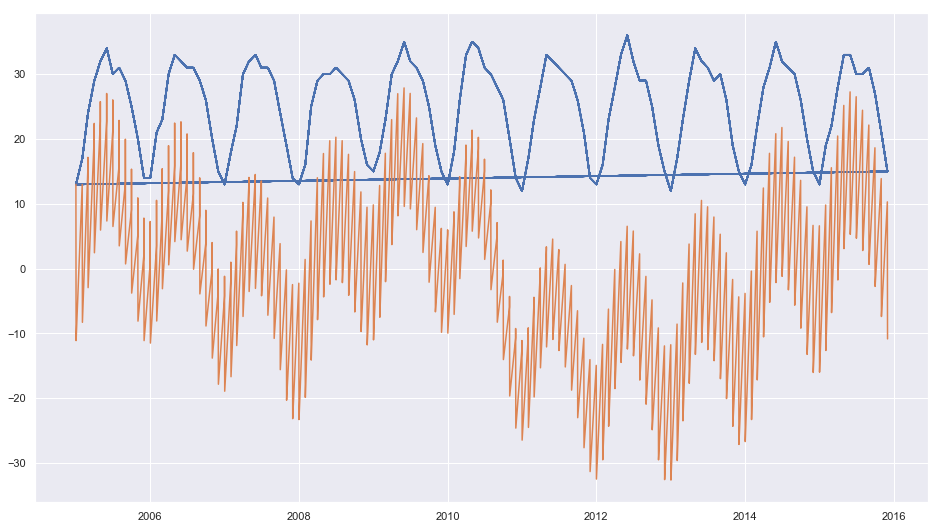

In [624]:
plt.plot(ts)
plt.plot(pred_log)

### Forecast are not accurate because on less features in data. 